In [14]:

from iminuit import Minuit
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
import jaxopt

import pandas as pd
import numpy as np
from lib.simdata_i3 import I3SimHandlerFtr
from lib.geo import center_track_pos_and_time_based_on_data
from lib.network import get_network_eval_v_fn
from lib.experimental_methods import remove_early_pulses
from dom_track_eval import get_eval_network_doms_and_track
from likelihood_spe import get_neg_c_triple_gamma_llh

# Event Index.
event_index = 3

# Get network and eval logic.
eval_network_v = get_network_eval_v_fn(bpath='/home/storage/hans/jax_reco/data/network')
eval_network_doms_and_track = get_eval_network_doms_and_track(eval_network_v)

# Get an IceCube event.
bp = '/home/storage2/hans/i3files/21217'
sim_handler = I3SimHandlerFtr(os.path.join(bp, 'meta_ds_21217_from_35000_to_53530.ftr'),
                              os.path.join(bp, 'pulses_ds_21217_from_35000_to_53530.ftr'),
                              '/home/storage/hans/jax_reco/data/icecube/detector_geometry.csv')

meta, pulses = sim_handler.get_event_data(event_index)
print(f"muon energy: {meta['muon_energy_at_detector']/1.e3:.1f} TeV")

# Get dom locations, first hit times, and total charges (for each dom).
event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)

print("n_doms", len(event_data))

# Make MCTruth seed.
track_pos = jnp.array([meta['muon_pos_x'], meta['muon_pos_y'], meta['muon_pos_z']])
track_time = meta['muon_time']
track_zenith = meta['muon_zenith']
track_azimuth = meta['muon_azimuth']
track_src = jnp.array([track_zenith, track_azimuth])

print("original seed vertex:", track_pos)
centered_track_pos, centered_track_time = center_track_pos_and_time_based_on_data(event_data, track_pos, track_time, track_src)
print("shifted seed vertex:", centered_track_pos)



muon energy: 2.2 TeV
n_doms 58
original seed vertex: [ 1180.18566012 -1499.16735802  -782.32800156]
shifted seed vertex: [-38.65768538 207.2454018  145.80801123]


In [15]:
# Create some n_photons from qtot (by rounding up).
n_photons = np.round(event_data['charge'].to_numpy()+0.5)

# Combine into single data tensor for fitting.
fitting_event_data = jnp.array(event_data[['x', 'y', 'z', 'time']].to_numpy())

# Clean random early events
fitting_event_data = fitting_event_data = remove_early_pulses(eval_network_doms_and_track, 
                                                              fitting_event_data, 
                                                              centered_track_pos, 
                                                              track_src, 
                                                              centered_track_time)

# Setup likelihood
neg_llh = get_neg_c_triple_gamma_llh(eval_network_doms_and_track)

In [35]:
scale = 20.0
@jax.jit
def neg_llh_5D(x, track_time, data):
        zenith = x[0] / scale
        azimuth = x[1] / scale
        zenith = jnp.fmod(zenith, 2.0*jnp.pi)
        zenith = jnp.where(zenith < 0, zenith+2.0*jnp.pi, zenith)
        cond = zenith > jnp.pi
        zenith = jnp.where(cond, -1.0*zenith+2.0*jnp.pi, zenith)
        azimuth = jnp.where(cond, azimuth-jnp.pi, azimuth)

        azimuth = jnp.fmod(azimuth, 2.0*jnp.pi)
        azimuth = jnp.where(azimuth < 0, azimuth+2.0*jnp.pi, azimuth)
        
        projected_dir = jnp.array([zenith, azimuth])
        return neg_llh(projected_dir, x[2:]*scale, track_time, data)


# Hack away endless logging by jaxopt
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout



solver = jaxopt.NonlinearCG(fun=neg_llh_5D,
#solver = jaxopt.LBFGS(fun=neg_llh_5D,
#solver = jaxopt.BFGS(fun=neg_llh_5D,
                       verbose=False,
                       min_stepsize=1e-3,
                       max_stepsize=1.0,
                       increase_factor=1.5,
                       maxiter=30,
                       maxls=30,
                       jit=True,
                       tol=0.001)

solve = jax.jit(solver.run)
x0 = jnp.concatenate([track_src*scale, centered_track_pos/scale])

with HiddenPrints():
    result = solve(x0, centered_track_time, fitting_event_data)
    
best_logl = result.state[1]
best_x = result.params

print("... solution found.")
print(f"-2*logl={best_logl:.3f}")
print(f"zenith={best_x[0]/scale:.3f}rad")
print(f"azimuth={best_x[1]/scale:.3f}rad")
print(f"x={best_x[2]*scale:.3f}m")
print(f"y={best_x[3]*scale:.3f}m")
print(f"z={best_x[4]*scale:.3f}m")
print(f"at fix time t={centered_track_time:.3f}ns")

print(neg_llh_5D(result.params, centered_track_time, fitting_event_data))

... solution found.
-2*logl=0.002
zenith=1.990rad
azimuth=5.346rad
x=-38.958m
y=209.022m
z=145.782m
at fix time t=12375.863ns
737.8325343308012


In [33]:
def run():
    with HiddenPrints():
        result = solve(x0, centered_track_time, fitting_event_data)
    return result.params.block_until_ready()

In [34]:
%timeit run()

519 ms ± 138 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
solver = jaxopt.LBFGSB(fun=neg_llh_5D,
                       verbose=False,
                       min_stepsize=1e-3,
                       max_stepsize=1.0,
                       increase_factor=1.5,
                       maxiter=30,
                       maxls=30,
                       history_size=30,
                       jit=True,
                       tol=0.001,
                       stop_if_linesearch_fails=True)

solve = jax.jit(solver.run)
x0 = jnp.concatenate([track_src*scale, centered_track_pos/scale])
bounds = (jnp.array([0.0, 0.0, -500/scale, -500.0/scale, -500.0/scale]),
          jnp.array([jnp.pi*scale, jnp.pi*2.0*scale, 500.0/scale, 500.0/scale, 500.0/scale]))


with HiddenPrints():
    result = solve(x0, bounds, centered_track_time, fitting_event_data)
    
best_logl = result.state[1]
best_x = result.params

print("... solution found.")
print(f"-2*logl={best_logl:.3f}")
print(f"zenith={best_x[0]/scale:.3f}rad")
print(f"azimuth={best_x[1]/scale:.3f}rad")
print(f"x={best_x[2]*scale:.3f}m")
print(f"y={best_x[3]*scale:.3f}m")
print(f"z={best_x[4]*scale:.3f}m")
print(f"at fix time t={centered_track_time:.3f}ns")

... solution found.
-2*logl=737.833
zenith=1.990rad
azimuth=5.346rad
x=-38.956m
y=209.021m
z=145.782m
at fix time t=12375.863ns


In [26]:
def run():
    with HiddenPrints():
        result = solve(x0, bounds, centered_track_time, fitting_event_data)
    return result.params.block_until_ready()

In [27]:
%timeit run()

87.5 ms ± 35.2 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [40]:
scale = 20.0
@jax.jit
def neg_llh_3D(x, track_dir, track_time, data):
    return neg_llh(track_dir, x*scale, track_time, data)

'''
solver = jaxopt.BFGS(fun=neg_llh_3D,
                       verbose=False,
                       min_stepsize=1e-3,
                       max_stepsize=1.0,
                       increase_factor=1.5,
                       maxiter=30,
                       maxls=30,
                       jit=True,
                       tol=0.001)
'''

solver = jaxopt.LBFGSB(fun=neg_llh_3D,
                       verbose=False,
                       min_stepsize=1e-3,
                       max_stepsize=1.0,
                       increase_factor=1.5,
                       maxiter=30,
                       maxls=30,
                       history_size=30,
                       jit=True,
                       tol=0.01,
                       stop_if_linesearch_fails=True)


bounds = (jnp.array([-500/scale, -500.0/scale, -500.0/scale]),
          jnp.array([500.0/scale, 500.0/scale, 500.0/scale]))


solve = jax.jit(solver.run)
x0 = centered_track_pos/scale

In [42]:
import time

time1 = time.time()
# Number of scan points on 1D
n_eval = 20 # making it a 30x30 grid

# Scan range (truth +/- dzen, +/- dazi)
dzen = 0.03 # rad
dazi = 0.03 # rad

zenith = jnp.linspace(track_src[0]-dzen, track_src[0]+dazi, n_eval)
azimuth = jnp.linspace(track_src[1]-dzen, track_src[1]+dazi, n_eval)
X, Y = jnp.meshgrid(zenith, azimuth)
init_dirs = jnp.column_stack([X.flatten(), Y.flatten()])

logls = np.zeros(len(init_dirs))

with HiddenPrints():
    for i, tdir in enumerate(init_dirs):
        result = solve(x0, bounds, tdir, centered_track_time, fitting_event_data)
        #result = solve(x0, tdir, centered_track_time, fitting_event_data)
        logls[i] = result.state[1]

logls = logls.reshape(X.shape)
time2 = time.time()

print(f"elapsed: {time2-time1}s")

elapsed: 60.41728401184082s


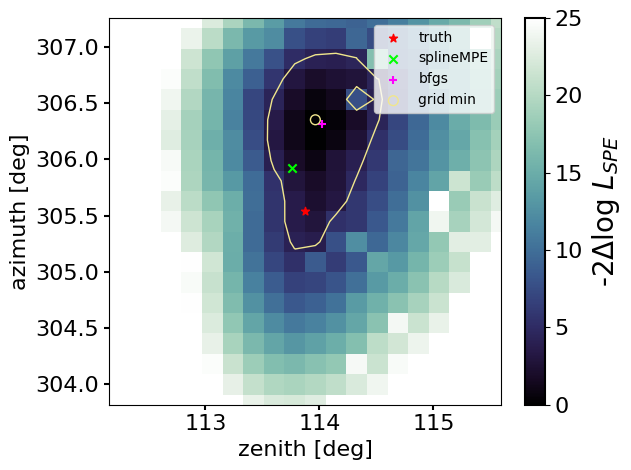

In [43]:
import matplotlib.pyplot as plt
from palettable.cubehelix import Cubehelix
cx =Cubehelix.make(start=0.3, rotation=-0.5, n=16, reverse=False, gamma=1.0,
                           max_light=1.0,max_sat=0.5, min_sat=1.4).get_mpl_colormap()


fig, ax = plt.subplots()
min_logl = np.amin(logls)
delta_logl = logls - np.amin(logls)
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), delta_logl, vmin=0, vmax=np.min([25, 1.2*np.amax(delta_logl)]), shading='auto', cmap=cx)
cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("-2$\\Delta$log $L_{SPE}$", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([track_src[0]-dzen, track_src[0]+dzen]))
ax.set_ylim(np.rad2deg([track_src[1]-dazi, track_src[1]+dazi]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="truth", zorder=200)

smpe_zenith = meta['spline_mpe_zenith']
smpe_azimuth = meta['spline_mpe_azimuth']
ax.scatter(np.rad2deg([smpe_zenith]), np.rad2deg([smpe_azimuth]), marker="x", color='lime', label='splineMPE')

zenith = best_x[0]
azimuth = best_x[1]
ax.scatter(np.rad2deg(zenith/scale), np.rad2deg(azimuth/scale), marker='+', color='magenta', label='bfgs')

contours = [4.61]
ix1, ix2 = np.where(delta_logl==0)
ax.scatter(np.rad2deg([X[ix1, ix2]]), np.rad2deg([Y[ix1, ix2]]), s=50, marker='o', facecolors='none', edgecolors='khaki', zorder=100., label='grid min')
ct = plt.contour(np.rad2deg(X), np.rad2deg(Y), delta_logl, levels=contours, linestyles=['solid'], colors=['khaki'], linewidths=1.0)

plt.legend()
plt.tight_layout()
plt.show()

In [28]:
from likelihood_spe import get_llh_and_grad_fs_for_iminuit_migrad
from likelihood_spe import get_llh_and_grad_fs_for_iminuit_migrad_profile

In [29]:
obj_fn, obj_grad = get_llh_and_grad_fs_for_iminuit_migrad(eval_network_doms_and_track)

# put the thing below into a for loop if you want to reconstruct many events (without jit-recompiling everything)
f_prime = lambda x: obj_fn(x, centered_track_time, fitting_event_data)
grad_prime = lambda x: obj_grad(x, centered_track_time, fitting_event_data)

x0 = jnp.concatenate([track_src, centered_track_pos])
m = Minuit(f_prime, x0, grad=grad_prime)
m.errordef = Minuit.LIKELIHOOD
m.limits = ((0.0, np.pi), (0.0, 2.0 * np.pi), (-500.0, 500.0),  (-500.0, 500.0),  (-500.0, 500.0))
m.strategy = 0
m.migrad()

best_logl=m.fval

print("best fit done. starting scan.")
print(f"logl is {m.fval}")
print(m.params)

best fit done. starting scan.
logl is 737.8325417627431
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  1.9901   │  0.0024   │            │            │    0    │ 3.14159 │       │
│ 1 │ x1   │  5.3462   │  0.0035   │            │            │    0    │ 6.28319 │       │
│ 2 │ x2   │    -39    │     2     │            │            │  -500   │   500   │       │
│ 3 │ x3   │   209.0   │    0.6    │            │            │  -500   │   500   │       │
│ 4 │ x4   │   145.8   │    0.9    │            │            │  -500   │   500   │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘


In [31]:
def run():
    m = Minuit(f_prime, x0, grad=grad_prime)
    m.errordef = Minuit.LIKELIHOOD
    m.limits = ((0.0, np.pi), (0.0, 2.0 * np.pi), (-500.0, 500.0),  (-500.0, 500.0),  (-500.0, 500.0))
    m.strategy = 0
    m.migrad()
    best_logl=m.fval
    return best_logl

%timeit run()

53.6 ms ± 82.7 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
# Now do the scan.
obj_f, obj_grad = get_llh_and_grad_fs_for_iminuit_migrad_profile(eval_network_doms_and_track)

def lets_profile(track_dir, obj_fn, obj_grad, vertex_seed, time, data):
    f_prime = lambda x: obj_fn(track_dir, x, time, data)
    grad_prime = lambda x: obj_grad(track_dir, x, time, data)

    x0 = jnp.array(vertex_seed)
    m = Minuit(f_prime, x0, grad=grad_prime)
    m.errordef = Minuit.LIKELIHOOD
    m.limits = ((-500.0, 500.0),  (-500.0, 500.0),  (-500.0, 500.0))
    m.strategy = 0
    m.migrad()
    return m.fval

In [19]:
import time
time1 = time.time()

# Number of scan points on 1D
n_eval = 20 # making it a 30x30 grid

# Scan range (truth +/- dzen, +/- dazi)
dzen = 0.03 # rad
dazi = 0.03 # rad

zenith = jnp.linspace(track_src[0]-dzen, track_src[0]+dazi, n_eval)
azimuth = jnp.linspace(track_src[1]-dzen, track_src[1]+dazi, n_eval)
X, Y = jnp.meshgrid(zenith, azimuth)
init_dirs = jnp.column_stack([X.flatten(), Y.flatten()])
logls = np.zeros(len(init_dirs))

for i, tdir in enumerate(init_dirs):
    logls[i] = lets_profile(tdir, obj_f, obj_grad,
            centered_track_pos,
            centered_track_time,
            fitting_event_data)

logls = logls.reshape(X.shape)
time2 = time.time()
print(f"elapsed: {time2-time1}s")

elapsed: 29.536015033721924s


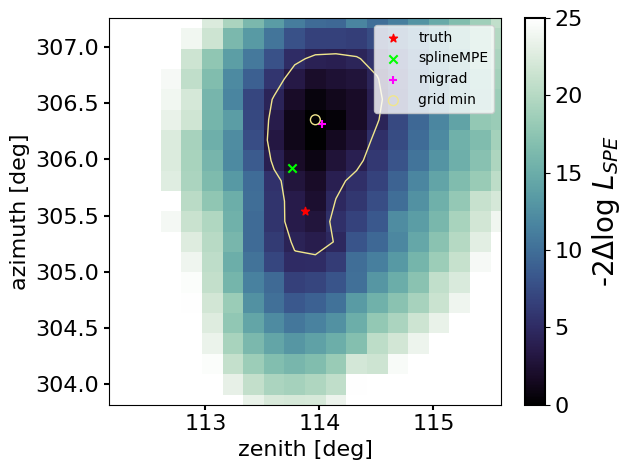

In [20]:
import matplotlib.pyplot as plt
from palettable.cubehelix import Cubehelix
cx =Cubehelix.make(start=0.3, rotation=-0.5, n=16, reverse=False, gamma=1.0,
                           max_light=1.0,max_sat=0.5, min_sat=1.4).get_mpl_colormap()


fig, ax = plt.subplots()
min_logl = np.amin(logls)
delta_logl = logls - min_logl
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), delta_logl, vmin=0, vmax=np.min([25, 1.2*np.amax(delta_logl)]), shading='auto', cmap=cx)
cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("-2$\\Delta$log $L_{SPE}$", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([track_src[0]-dzen, track_src[0]+dzen]))
ax.set_ylim(np.rad2deg([track_src[1]-dazi, track_src[1]+dazi]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="truth", zorder=200)

smpe_zenith = meta['spline_mpe_zenith']
smpe_azimuth = meta['spline_mpe_azimuth']
ax.scatter(np.rad2deg([smpe_zenith]), np.rad2deg([smpe_azimuth]), marker="x", color='lime', label='splineMPE')

zenith = m.values[0]
azimuth = m.values[1]
ax.scatter(np.rad2deg(zenith), np.rad2deg(azimuth), marker='+', color='magenta', label='migrad')

contours = [4.61]
ix1, ix2 = np.where(delta_logl==0)
ax.scatter(np.rad2deg([X[ix1, ix2]]), np.rad2deg([Y[ix1, ix2]]), s=50, marker='o', facecolors='none', edgecolors='khaki', zorder=100., label='grid min')
ct = plt.contour(np.rad2deg(X), np.rad2deg(Y), delta_logl, levels=contours, linestyles=['solid'], colors=['khaki'], linewidths=1.0)

plt.legend()
plt.tight_layout()
plt.show()